# Start

In [1]:
# !pip install git+https://github.com/qubvel/segmentation_models
!pip install -U segmentation-models==0.2.1
!pip install albumentations

     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 


In [2]:
import os, sys, gc

import pandas as pd
import numpy  as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto       import tqdm
from multiprocessing import Pool, cpu_count

from cv2        import resize
from skimage.io import imread     as skiImgRead
# from imgaug     import augmenters as iaa, HooksImages

from skimage.morphology import label

from sklearn.model_selection import train_test_split

from segmentation_models           import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.utils     import set_trainable
from segmentation_models.losses    import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics   import iou_score, f2_score

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
IMG_HW    = 768
ZOOM_HW   = 384

DATA_DIR  = '../input/airbus-ship-detection'
TRAIN_DIR = os.path.join(DATA_DIR, 'train_v2')
TEST_DIR  = os.path.join(DATA_DIR, 'test_v2')

BACKBONE  = 'resnet34'

preprocess_input = get_preprocessing(BACKBONE)

In [4]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_HW*IMG_HW, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(IMG_HW,IMG_HW).T


def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
def count_pix_inpool(df_col):
    pool = Pool()
    res = pool.map( count_pix, df_col.items() )
    pool.close()
    pool.join()
    return res

def count_pix(row):
    v = row[1]
    if v is np.nan or type(v) != str: 
        return v
    else:
        return rle_decode(v).sum()

# Load data

In [6]:
train_csv  = pd.read_csv( os.path.join( DATA_DIR, 'train_ship_segmentations_v2.csv') )
train_csv['withShip'] = ~train_csv['EncodedPixels'].isnull()
train_csv['npixel'] = count_pix_inpool( train_csv['EncodedPixels'] )

# EDA

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


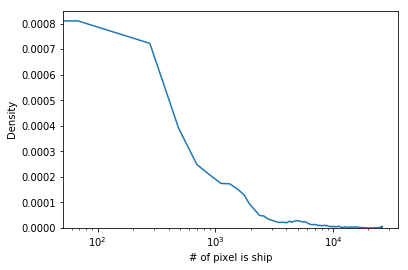

In [7]:
sns.kdeplot(train_csv['npixel'])
plt.xscale('log')
plt.legend().set_visible(False)
plt.xlabel('# of pixel is ship')
plt.ylabel('Density')
plt.show()

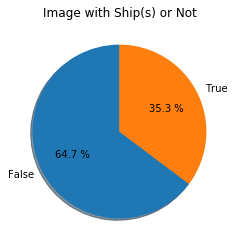

In [8]:
plt.pie(
    x       = (train_csv['withShip'].value_counts()/train_csv.shape[0]).values, 
    labels  = (train_csv['withShip'].value_counts()/train_csv.shape[0]).index,
    autopct = '%3.1f %%',
    shadow  = True, 
    labeldistance = 1.1, 
    startangle  = 90,
    pctdistance = 0.6
);
plt.title('Image with Ship(s) or Not');
plt.show()

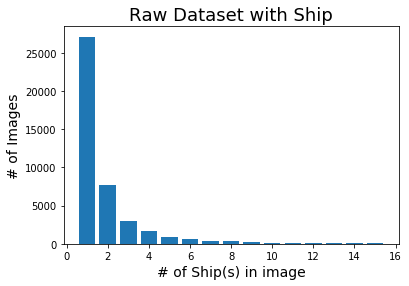

In [9]:
figdf = train_csv.dropna().groupby('ImageId').count()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('# of Ship(s) in image', fontsize=14)
plt.ylabel('# of Images', fontsize=14)
plt.title('Raw Dataset with Ship', fontsize=18)
plt.show()

In [10]:
np.sqrt( train_csv['npixel'].min() )

1.4142135623730951

# Balance the data

In [11]:
DROP_NO_SHIP_FRACTION = 0.8

balanced_train_csv = (
    train_csv
    .set_index('ImageId')
    .drop(
        train_csv.loc[
            train_csv.isna().any(axis=1),
            'ImageId'
        ].sample( frac = DROP_NO_SHIP_FRACTION )
    )
    .drop(
        train_csv.query('npixel<32')['ImageId']
    )
    .reset_index()
)

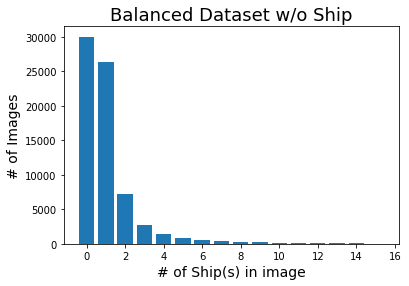

In [12]:
figdf = balanced_train_csv.fillna(0).groupby('ImageId').sum()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('# of Ship(s) in image', fontsize=14)
plt.ylabel('# of Images', fontsize=14)
plt.title('Balanced Dataset w/o Ship', fontsize=18)
plt.show()

# Generate data for model

In [13]:
b_train_csv, b_valid_csv = train_test_split(balanced_train_csv['ImageId'], test_size = 0.2)

b_train_csv = balanced_train_csv.set_index('ImageId').loc[b_train_csv].reset_index()
b_valid_csv = balanced_train_csv.set_index('ImageId').loc[b_valid_csv].reset_index()

In [14]:
def batch_data_gen(csv_df, dir_prefix, batch_size, augmentation=None):
    name_idx_df = csv_df.set_index('ImageId')

#     img_ids = name_idx_df.index.unique().to_numpy()
    img_ids = np.array( name_idx_df.index.unique().tolist() )

    n_imgs  = img_ids.shape[0]
    
    while True:
        np.random.shuffle(img_ids)
        for idx in range(0, n_imgs, batch_size):
            batch_x = np.zeros( (batch_size,) + (ZOOM_HW, ZOOM_HW, 3) )
            batch_y = np.zeros( (batch_size,) + (ZOOM_HW, ZOOM_HW, 1) )

            end_idx = idx + batch_size
            batch_img_ids = img_ids[idx:end_idx]
            
            for i,img_id in enumerate(batch_img_ids):
                img_df = name_idx_df.loc[[img_id]]
                x, y = load_paired_data(img_df, dir_prefix, augmentation=augmentation)
                batch_x[i] += x
                batch_y[i] += y
            
            yield batch_x, batch_y



def load_paired_data(df, dir_prefix, augmentation=None):
    img_id = df.index.unique()[0]

    try:
        image = preprocess_input( skiImgRead( os.path.join(dir_prefix, img_id) ) )
    except:
        image = preprocess_input( np.zeros((IMG_HW, IMG_HW, 3), dtype=np.uint8) )

    mask = np.zeros((IMG_HW, IMG_HW, 1))
    for _,mask_rle in df['EncodedPixels'].iteritems():
        if mask_rle is np.nan:
            continue
        mask[:,:,0] += rle_decode(mask_rle)

    if augmentation:
        augmented = augmentation(image=image, mask=mask)
        image = augmented['image']
        mask  = augmented['mask']
    
    image = resize(image, (ZOOM_HW,ZOOM_HW))
    mask  = resize(mask.reshape(IMG_HW,IMG_HW), (ZOOM_HW,ZOOM_HW)).reshape((ZOOM_HW,ZOOM_HW,1))
    return image, mask

In [15]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Transpose,
    OneOf, ToFloat,
    RandomBrightness, RandomContrast, RandomGamma, CLAHE,
    GridDistortion, ElasticTransform, JpegCompression,
    RGBShift, GaussNoise, IAAAdditiveGaussianNoise, HueSaturationValue,
    Blur, MotionBlur, MedianBlur, RandomBrightnessContrast,
    GridDistortion, OpticalDistortion, RandomSizedCrop, CenterCrop
)

augmentor = Compose([
    OneOf([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        Transpose(),
    ], p=0.8), 
    ShiftScaleRotate(rotate_limit=20),
    OneOf([
        MotionBlur(blur_limit=3),
        MedianBlur(blur_limit=3),
        Blur(blur_limit=3),
    ], p=0.3),
    OneOf([
        RandomGamma(),
        RandomContrast(),
        RandomBrightness(),
        CLAHE(),
     ], p=0.3),
    OneOf([
        IAAAdditiveGaussianNoise(),
        HueSaturationValue(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        ElasticTransform(),
        OpticalDistortion(),
        GridDistortion(),
    ], p=0.3),
    RandomSizedCrop(min_max_height=(IMG_HW/2, IMG_HW), height=IMG_HW, width=IMG_HW, p=0.3),
    ToFloat(max_value=1),
],p=1)

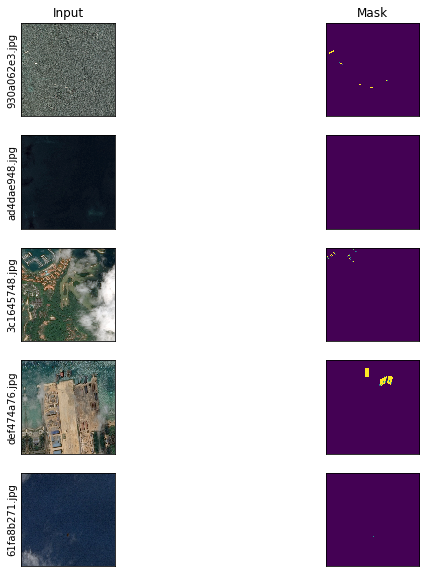

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 10), sharex=True, sharey=True)

for i, img_id in enumerate( np.random.choice(train_csv.dropna()['ImageId'].unique(), 5) ):
#     print (img_id)
    img_df = train_csv.set_index('ImageId').loc[[img_id]]
    x, y = load_paired_data(img_df, TRAIN_DIR, augmentation=augmentor)

    axs[i,0].set_ylabel(img_id)
    axs[i,0].imshow(x/255)
    axs[i,1].imshow(y[:,:,0])

axs[0,0].set_title('Input')
axs[0,1].set_title('Mask')

plt.xticks([])
plt.yticks([])

plt.show()

In [17]:
model = Unet(
    BACKBONE, 
    encoder_weights='imagenet',
    classes=1, 
    activation='sigmoid', 
    input_shape=(ZOOM_HW, ZOOM_HW, 3),
    decoder_filters=(128, 64, 32, 16, 8),
)

# model.compile('Adam', loss='binary_crossentropy')
model.compile(optimizer='Adam', loss=bce_dice_loss, metrics=[iou_score])
# model.compile(optimizer='Adadelta', loss=bce_dice_loss, metrics=[iou_score])

85524480/85521592 [==============================] - 2s 0us/step


In [18]:
BATCH_SIZE = 32

In [19]:
b_train_csv['ImageId'].unique().shape[0]//BATCH_SIZE

1839

In [20]:
checkpoint = ModelCheckpoint(
    filepath='./best_model.h5', 
    monitor='val_iou_score', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)

reduce_lr  = ReduceLROnPlateau(
    monitor='val_loss', mode='min', 
    factor=0.3, patience=3, min_lr=0.00001, 
    verbose=1
)


In [21]:
history = model.fit_generator(
    generator        = batch_data_gen(b_train_csv, TRAIN_DIR, BATCH_SIZE, augmentation=None), 
    validation_data  = batch_data_gen(b_valid_csv, TRAIN_DIR, BATCH_SIZE), 
    validation_steps = 50,
    steps_per_epoch  = 500,
    epochs           = 20,
    verbose = 2,
    callbacks=[ checkpoint, reduce_lr ]
)

Epoch 1/20
 - 671s - loss: 0.6912 - iou_score: 0.3382 - val_loss: 0.6108 - val_iou_score: 0.4181

Epoch 00001: val_iou_score improved from -inf to 0.41808, saving model to ./best_model.h5
Epoch 2/20
 - 640s - loss: 0.3179 - iou_score: 0.6847 - val_loss: 0.3809 - val_iou_score: 0.5941

Epoch 00002: val_iou_score improved from 0.41808 to 0.59409, saving model to ./best_model.h5
Epoch 3/20
 - 643s - loss: 0.2854 - iou_score: 0.7222 - val_loss: 0.4645 - val_iou_score: 0.5465

Epoch 00003: val_iou_score did not improve from 0.59409
Epoch 4/20
 - 630s - loss: 0.2880 - iou_score: 0.7154 - val_loss: 0.3714 - val_iou_score: 0.6006

Epoch 00004: val_iou_score improved from 0.59409 to 0.60055, saving model to ./best_model.h5
Epoch 5/20
 - 605s - loss: 0.2881 - iou_score: 0.7251 - val_loss: 0.9113 - val_iou_score: 0.4089

Epoch 00005: val_iou_score did not improve from 0.60055
Epoch 6/20
 - 617s - loss: 0.3124 - iou_score: 0.6987 - val_loss: 0.3547 - val_iou_score: 0.6137

Epoch 00006: val_iou_sco

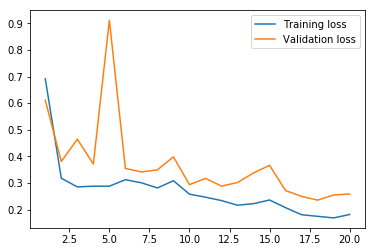

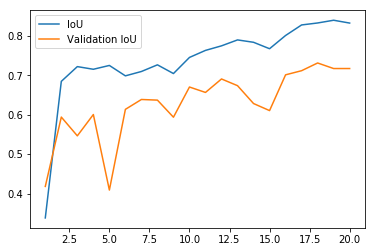

In [22]:
los  = model.history.history['loss']
vlos = model.history.history['val_loss']
iou  = model.history.history['iou_score']
viou = model.history.history['val_iou_score']

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, los,  label='Training loss')
plt.plot(epochs, vlos, label='Validation loss')
plt.legend()
plt.show()

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, iou,  label='IoU')
plt.plot(epochs, viou, label='Validation IoU')
plt.legend()
plt.show()


In [23]:
model.load_weights('best_model.h5')

In [24]:
lrs = LearningRateScheduler(lambda epoch: 0.001 * 0.3 ** (epoch // 2))
                      
history = model.fit_generator(
    generator        = batch_data_gen(b_train_csv, TRAIN_DIR, BATCH_SIZE, augmentation=augmentor), 
    validation_data  = batch_data_gen(b_valid_csv, TRAIN_DIR, BATCH_SIZE), 
    validation_steps = 20,
    steps_per_epoch  = 150,
    epochs           = 10,
    verbose = 2,
    callbacks=[ checkpoint, lrs ],
)

Epoch 1/10
 - 918s - loss: 0.2361 - iou_score: 0.7716 - val_loss: 0.2528 - val_iou_score: 0.7244

Epoch 00001: val_iou_score did not improve from 0.73136
Epoch 2/10
 - 917s - loss: 0.2748 - iou_score: 0.7296 - val_loss: 0.3465 - val_iou_score: 0.6420

Epoch 00002: val_iou_score did not improve from 0.73136
Epoch 3/10
 - 892s - loss: 0.2505 - iou_score: 0.7654 - val_loss: 0.2888 - val_iou_score: 0.6841

Epoch 00003: val_iou_score did not improve from 0.73136
Epoch 4/10
 - 891s - loss: 0.2498 - iou_score: 0.7582 - val_loss: 0.3023 - val_iou_score: 0.6795

Epoch 00004: val_iou_score did not improve from 0.73136
Epoch 5/10
 - 861s - loss: 0.2422 - iou_score: 0.7655 - val_loss: 0.2700 - val_iou_score: 0.6964

Epoch 00005: val_iou_score did not improve from 0.73136
Epoch 6/10
 - 958s - loss: 0.2308 - iou_score: 0.7737 - val_loss: 0.3085 - val_iou_score: 0.6597

Epoch 00006: val_iou_score did not improve from 0.73136
Epoch 7/10
 - 907s - loss: 0.2242 - iou_score: 0.7836 - val_loss: 0.3146 - v

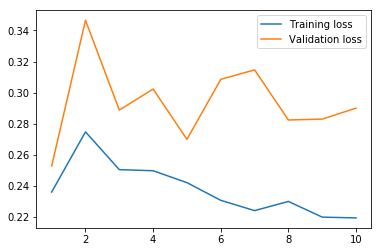

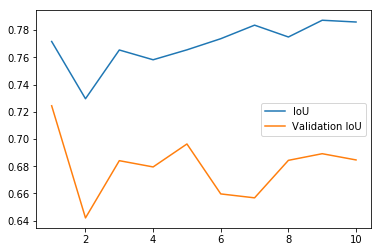

In [25]:
los  = model.history.history['loss']
vlos = model.history.history['val_loss']
iou  = model.history.history['iou_score']
viou = model.history.history['val_iou_score']

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, los,  label='Training loss')
plt.plot(epochs, vlos, label='Validation loss')
plt.legend()
plt.show()

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, iou,  label='IoU')
plt.plot(epochs, viou, label='Validation IoU')
plt.legend()
plt.show()

In [26]:
model.load_weights('best_model.h5')

82539139f.jpg
64e9e8e66.jpg
cc317192d.jpg
4249fec85.jpg
e2ed354e7.jpg


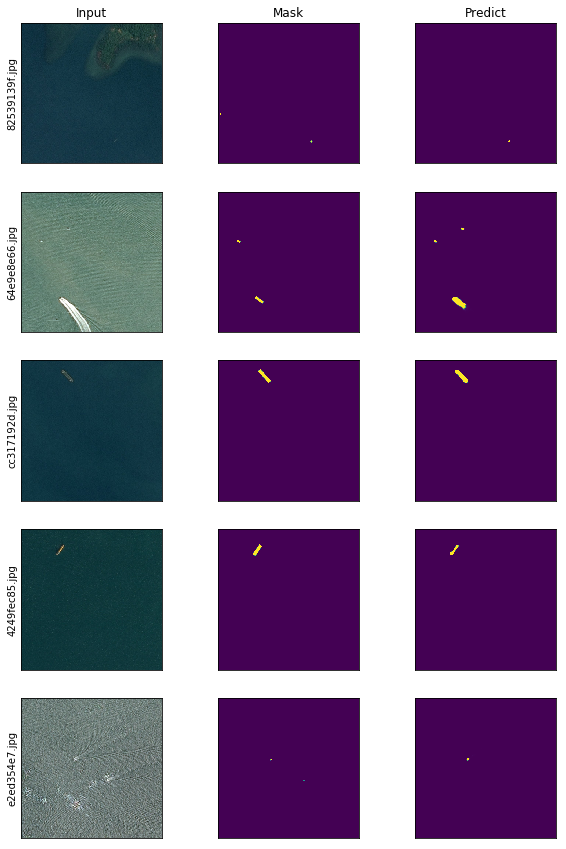

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(10, 15), sharex=True, sharey=True)

for i, img_id in enumerate( np.random.choice(train_csv.dropna()['ImageId'].unique(), 5) ):
    print (img_id)
    img_df = train_csv.set_index('ImageId').loc[[img_id]]
    x, y = load_paired_data(img_df, TRAIN_DIR)
    yp = model.predict( np.expand_dims(preprocess_input(x), axis=0) )

    axs[i,0].set_ylabel(img_id)
    axs[i,0].imshow(x)
    axs[i,1].imshow(y[:,:,0])
    axs[i,2].imshow(yp[0,:,:,0])

axs[0,0].set_title('Input')
axs[0,1].set_title('Mask')
axs[0,2].set_title('Predict')

plt.xticks([])
plt.yticks([])

plt.show()

In [28]:
sub_csv = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for test_id in tqdm( os.listdir( TEST_DIR ) ):
    fp  = os.path.join( TEST_DIR, test_id )
    img = skiImgRead(fp)
    assert ( img.shape == (IMG_HW, IMG_HW, 3) ), 'Bad Shape in image: "{}"'.format(fp)

    img = resize(img, (ZOOM_HW, ZOOM_HW))

    # TTA
    imgTTA1 = preprocess_input(img).reshape(1, ZOOM_HW, ZOOM_HW, 3)
    
    imgTTA1 = imgTTA1[:, :: 1, :: 1, :]
    imgTTA2 = imgTTA1[:, :: 1, ::-1, :]
    imgTTA3 = imgTTA1[:, ::-1, :: 1, :]
    imgTTA4 = imgTTA1[:, ::-1, ::-1, :]
    
    (rTTA1,rTTA2,rTTA3,rTTA4) = model.predict( np.concatenate( [imgTTA1, imgTTA2, imgTTA3, imgTTA4] ) )[:,:,:,0]

    result = (
        rTTA1[:: 1, :: 1] + 
        rTTA2[:: 1, ::-1] + 
        rTTA3[::-1, :: 1] + 
        rTTA4[::-1, ::-1]
    )/4
    
    result = resize(result, (IMG_HW, IMG_HW))
    labels = label( (result>0.5)+0 )

    
    # No Ship
    if labels.max() == 0:
        sub_csv = sub_csv.append({'ImageId':test_id}, ignore_index=True)
    else:
        for k in np.unique(labels[labels>0]):
            sub_csv = sub_csv.append(
                {
                    'ImageId'      : test_id, 
                    'EncodedPixels': rle_encode(labels==k)
                }, ignore_index=True)
#     break

In [29]:
sub_csv.to_csv('submission.csv', index=False)